In [1]:
import tensorflow as tf
tf.config.optimizer.set_jit(False)


from pathlib import Path

import shutil

import os
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.patches as patches

%matplotlib inline

d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Define paths

In [2]:

PROJECT_PATH = './'                               
WORKSPACE_PATH = PROJECT_PATH + '/workspace'        

TFOD_MODELS_PATH = PROJECT_PATH + '/workspace/pre_trained_models/models'   
PRETRAINED_MODEL_PATH = WORKSPACE_PATH + '/pre_trained_models' 

CUSTOM_MODEL_NAME = 'aquarium_model_ssd_reset50'

CUSTOM_MODEL_PATH = WORKSPACE_PATH + '/models'     

# ANNOTATION_PATH = WORKSPACE_PATH + '/annotations'
ANNOTATION_PATH = 'data/test/creatures_label_map.pbtxt' 

train_data_path = 'data/train/'
test_data_path = 'data/test/'
valid_data_path = 'data/valid/'

Path(CUSTOM_MODEL_PATH).mkdir(parents=True, exist_ok=True)

Path(CUSTOM_MODEL_PATH + '/' + CUSTOM_MODEL_NAME).mkdir(parents=True, exist_ok=True)

In [3]:
MODEL_TYPE = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'

In [4]:
# import object_detection module

from google.protobuf import text_format

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2, string_int_label_map_pb2

## Load the label map

In [5]:
def load_label_map(label_map_path):
    label_map = string_int_label_map_pb2.StringIntLabelMap()
    with open(label_map_path, 'r') as f:
        text_format.Merge(f.read(), label_map)

    label_map_dict = {}
    for item in label_map.item:
        label_map_dict[item.id] = item.name

    return label_map_dict

# Load the label map
label_map_path = ANNOTATION_PATH  # replace with your actual label map path
label_map_dict = load_label_map(label_map_path)

# Now you can get the class name using the class ID
class_id = 2
class_name = label_map_dict[class_id]

print(label_map_dict)

{1: 'fish', 2: 'jellyfish', 3: 'penguin', 4: 'puffin', 5: 'shark', 6: 'starfish', 7: 'stingray'}


## Preview the data

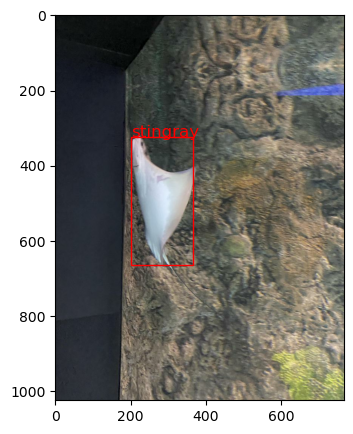

In [6]:
## preview the data
import matplotlib.patches as patches

%matplotlib inline

def parse_tfrecord(tfrecord):
    # Define the features in the tfrecord file
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    example = tf.io.parse_single_example(tfrecord, feature_description)

    # Decode the image
    image = tf.io.decode_image(example['image/encoded'], channels=3)

    
    xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'])
    bbox = tf.stack([ymin, xmin, ymax, xmax], axis=-1)
    
    labels = tf.sparse.to_dense(example['image/object/class/label'])

    return image, bbox, labels


def draw_bboxes(ax, image, bboxes, labels):
    ax.imshow(image)

    for bbox, label in zip(bboxes, labels):
        ymin, xmin, ymax, xmax = bbox
        label_name = label_map_dict[label]  # convert label ID to label name
        rect = patches.Rectangle((xmin*image.shape[1], ymin*image.shape[0]), 
                                 (xmax-xmin)*image.shape[1], 
                                 (ymax-ymin)*image.shape[0], 
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin*image.shape[1], 
                ymin*image.shape[0], 
                label_name, 
                fontsize=12, 
                color='r')


# Load the tfrecord file (replace filename with your tfrecord file)
raw_dataset = tf.data.TFRecordDataset(train_data_path + 'creatures.tfrecord')

# Get the first record (if you want to get other records, use .skip(n))
skip_image = 5
first_record = next(iter(raw_dataset.skip(skip_image)))

# Parse the record
image, bbox, labels = parse_tfrecord(first_record)
image_np = np.array(image)

# Convert tensor bboxes to numpy for plotting
bbox_np = np.array(bbox)
labels_np = np.array(labels)

fig, axs = plt.subplots(1, figsize=(10,5))
draw_bboxes(axs, image_np, bbox_np, labels_np,)

plt.show()



## Prepare the config file

In [7]:
#Copy the config file from the pretrained model to the custom model
#check if the config file exists
# if not os.path.exists(PRETRAINED_MODEL_PATH + '/'+ MODEL_TYPE +'/pipeline.config'): 
#shutil.move(PRETRAINED_MODEL_PATH + '/'+ MODEL_TYPE +'/pipeline.config', CUSTOM_MODEL_PATH + '/' + CUSTOM_MODEL_NAME + '/')

CONFIG_PATH = CUSTOM_MODEL_PATH + '/' + CUSTOM_MODEL_NAME + '/pipeline.config'

In [8]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
config

{'model': ssd {
   num_classes: 7
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
 

In [9]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [10]:
pipeline_config.model.ssd.num_classes = 7
pipeline_config.train_config.batch_size = 2
pipeline_config.train_config.num_steps = 3000   # limited no. of steps configured here, but use 100k to 200K steps for good results

# As we are not training from scratch, providing check point of pretrained model
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH + '/' + MODEL_TYPE + '/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection" # type

pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH 

pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = ['data/train/creatures.tfrecord']

pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH 

pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = ['data/valid/creatures.tfrecord']



In [11]:
pipeline_config

model {
  ssd {
    num_classes: 7
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_resnet50_v1_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 0.00039999998989515007
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.029999999329447746
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      ar

In [12]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:
    f.write(config_text)

In [13]:
num_steps = 3000

print(f"python {TFOD_MODELS_PATH}/research/object_detection/model_main_tf2.py --model_dir={CUSTOM_MODEL_PATH}/{CUSTOM_MODEL_NAME} --pipeline_config_path={CUSTOM_MODEL_PATH}/{CUSTOM_MODEL_NAME}/pipeline.config --num_train_steps={num_steps}")

python .//workspace/pre_trained_models/models/research/object_detection/model_main_tf2.py --model_dir=.//workspace/models/aquarium_model_ssd_reset50 --pipeline_config_path=.//workspace/models/aquarium_model_ssd_reset50/pipeline.config --num_train_steps=3000


In [14]:
import tensorflow as tf

# Check if TensorFlow is able to see your GPU
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
## make sure you have CUDA 11.3 installed

!echo %CUDA_DIR%

C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.3


## Train the model

In [16]:
!python .//workspace/pre_trained_models/models/research/object_detection/model_main_tf2.py --model_dir=.//workspace/models/aquarium_model_ssd_reset50 --pipeline_config_path=.//workspace/models/aquarium_model_ssd_reset50/pipeline.config --num_train_steps=6000

d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues

In [17]:
Path("/workspace/models/aquarium_model_ssd_reset50/exported_models").mkdir(parents=True, exist_ok=True)

In [18]:
os.chdir(PROJECT_PATH)

## Save the model

In [19]:
!python .//workspace/pre_trained_models/models/research/object_detection//exporter_main_v2.py --input_type image_tensor --pipeline_config_path .//workspace/models/aquarium_model_ssd_reset50/pipeline.config --trained_checkpoint_dir .//workspace/models/aquarium_model_ssd_reset50/ --output_directory .//workspace/models/aquarium_model_ssd_reset50/exported_models

d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
2023-08-02 02:06:03.803083: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 02:06:05.313499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2597 MB memory:  -> devi

# Load the model for testing

In [20]:
import matplotlib
import matplotlib.pyplot as plt

import time
import numpy as np
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import os

%matplotlib inline


In [21]:
os.chdir(PROJECT_PATH)

In [22]:
PATH_TO_SAVED_MODEL = "./workspace/models/aquarium_model_ssd_reset50/exported_models/saved_model"


print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detector = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 11.096041440963745 seconds


In [23]:

infer = detector.signatures["serving_default"]
# Get the list of trainable variables
variables = infer.trainable_variables

# Compute the total number of trainable parameters
total_params = np.sum([np.prod(v.shape) for v in variables])

# The number of layers with trainable parameters is just the number of variables
num_layers = len(variables)

print('Total number of trainable parameters:', total_params)
print('Number of layers with trainable parameters:', num_layers)


Total number of trainable parameters: 31692680
Number of layers with trainable parameters: 269


In [24]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH, use_display_name=True)

print(category_index)

{1: {'id': 1, 'name': 'fish'}, 2: {'id': 2, 'name': 'jellyfish'}, 3: {'id': 3, 'name': 'penguin'}, 4: {'id': 4, 'name': 'puffin'}, 5: {'id': 5, 'name': 'shark'}, 6: {'id': 6, 'name': 'starfish'}, 7: {'id': 7, 'name': 'stingray'}}


In [25]:
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

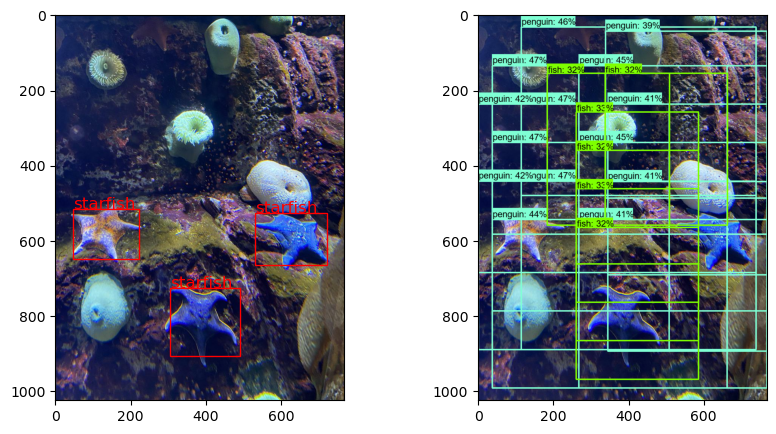

In [26]:
test_dataset = tf.data.TFRecordDataset(test_data_path + 'creatures.tfrecord')

# Get the first record (if you want to get other records, use .skip(skip_image))
skip_image = 0
first_test_record = next(iter(test_dataset.skip(skip_image)))

# Parse the record
image, bbox, labels = parse_tfrecord(first_test_record)
image_np = np.array(image)

# Convert tensor bboxes to numpy for plotting
bbox_np = np.array(bbox)
labels_np = np.array(labels)

fig, axs = plt.subplots(1,2,figsize=(10,5))
draw_bboxes(axs[0], image_np, bbox_np, labels_np,)

image_np = image.numpy()
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

# Apply model to the image
detections = detector(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# Detection classes should be ints
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()
image_np_with_detections_uint8 = image_np_with_detections.astype(np.uint8)

# Visualize the predicted bboxes on the image
viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections_uint8,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=20,
        min_score_thresh=.30,
        agnostic_mode=False)

plt.subplot(1, 2, 2)
plt.imshow(image_np_with_detections_uint8)
plt.show()

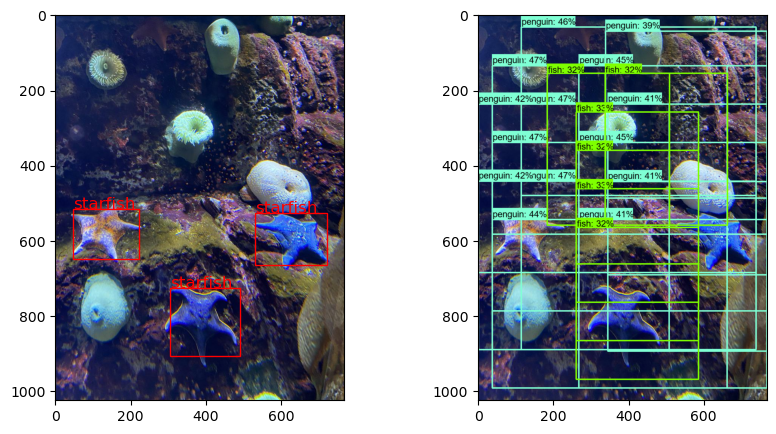

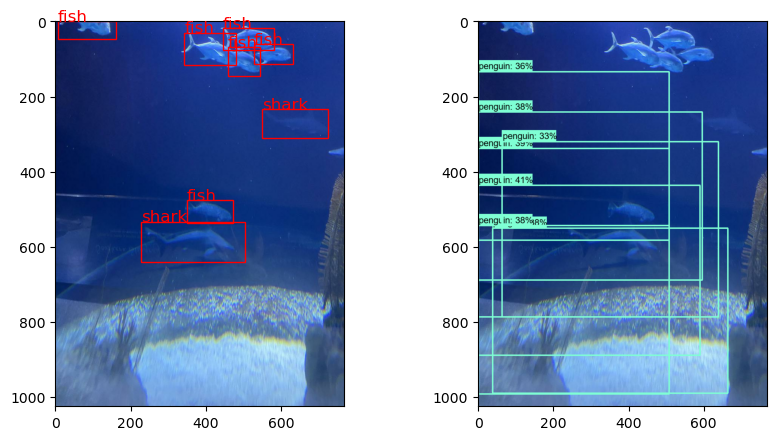

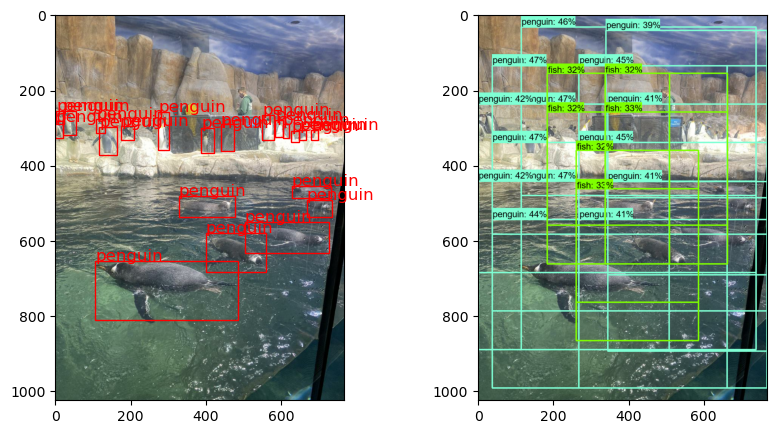

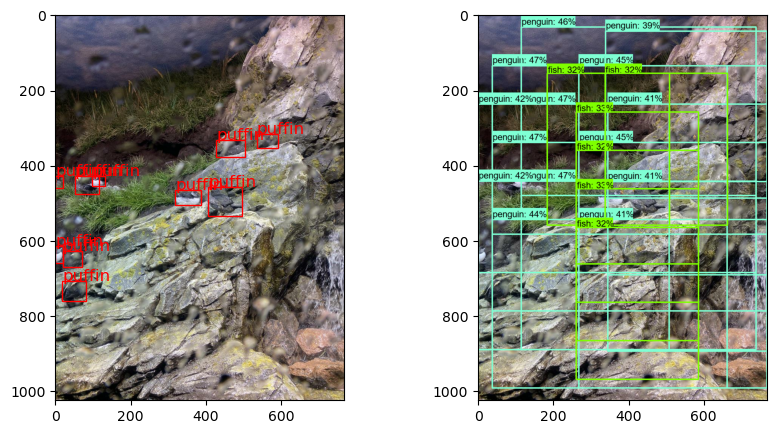

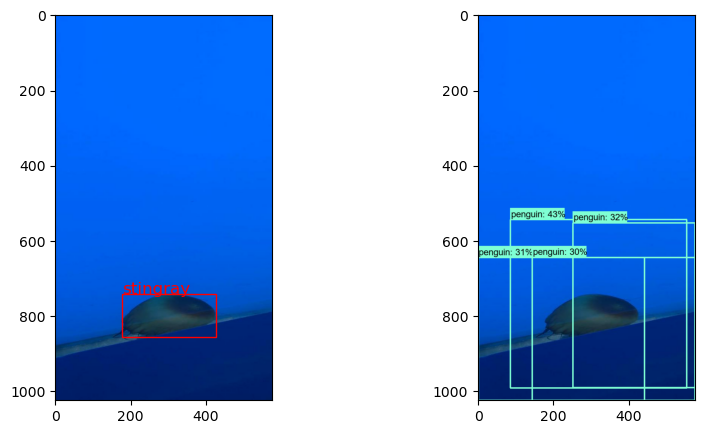

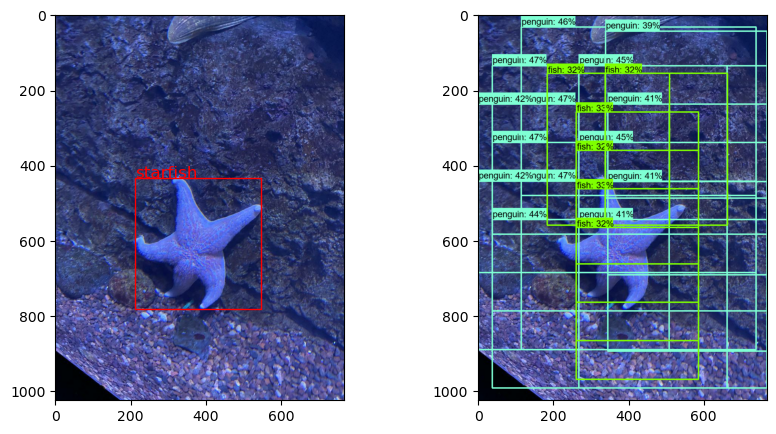

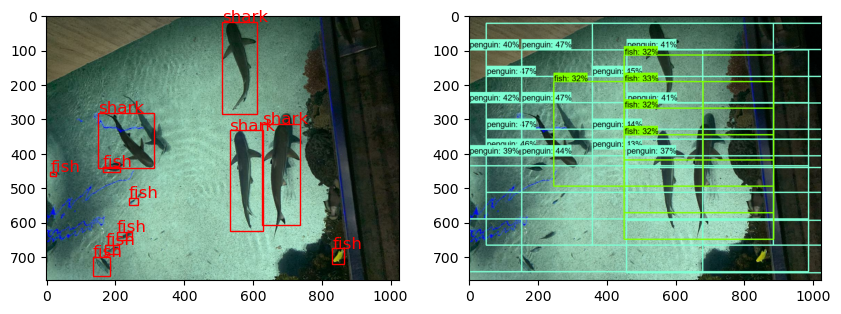

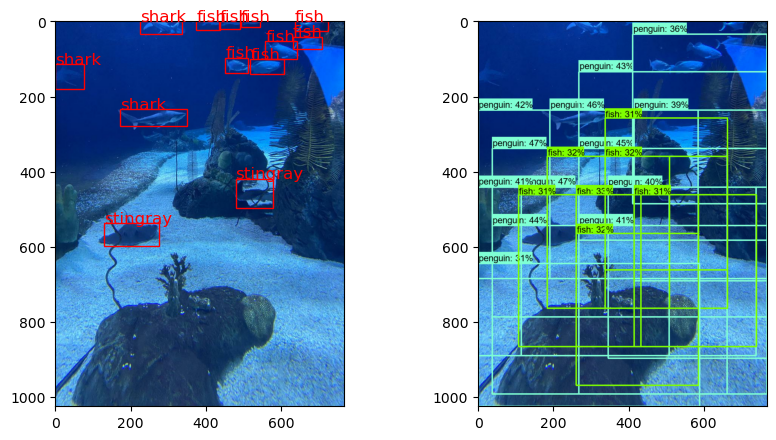

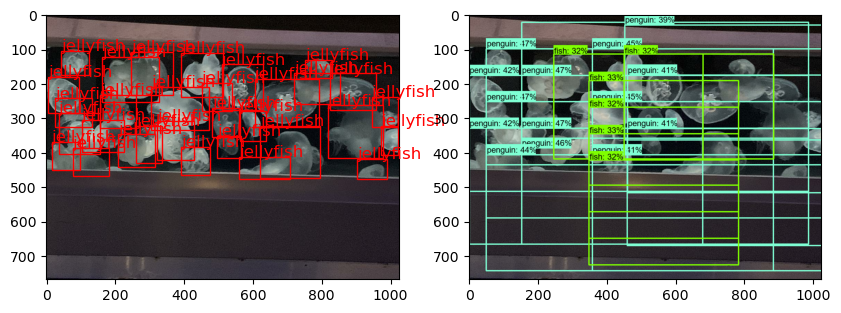

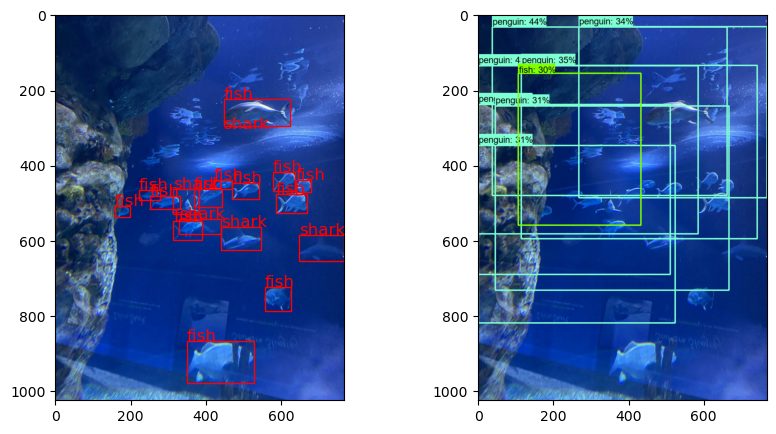

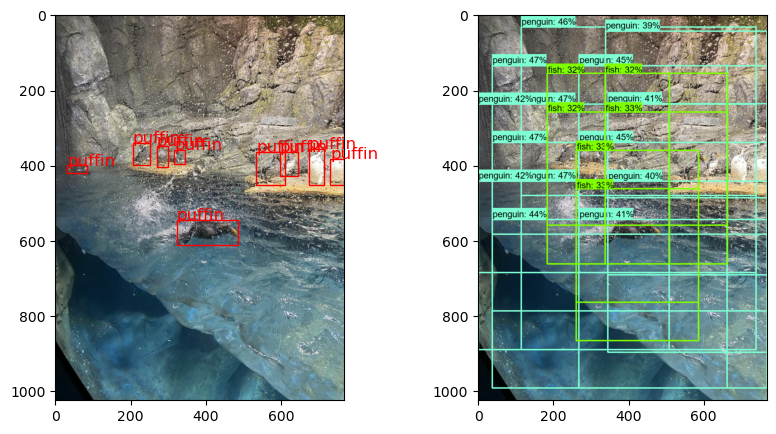

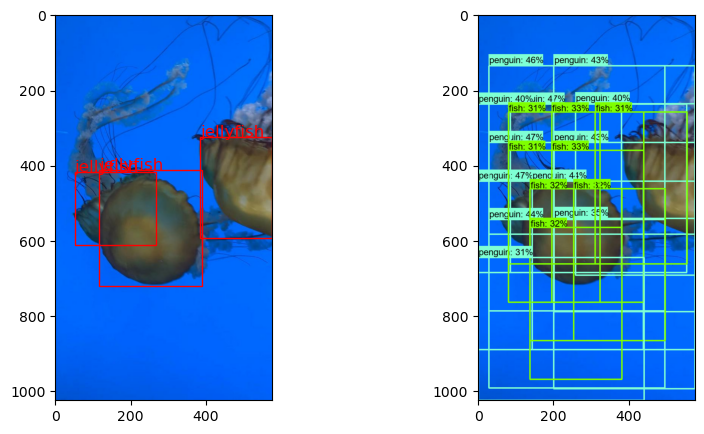

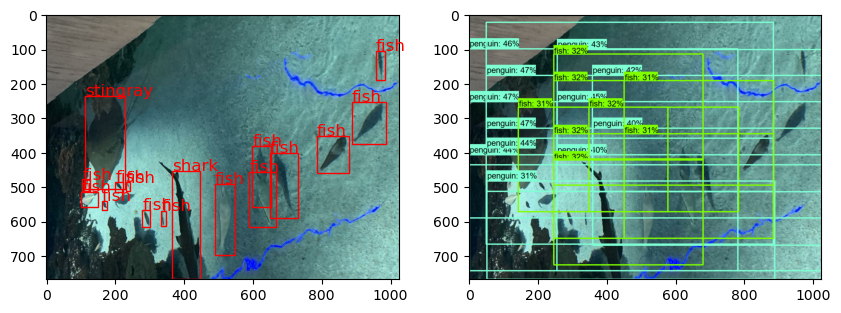

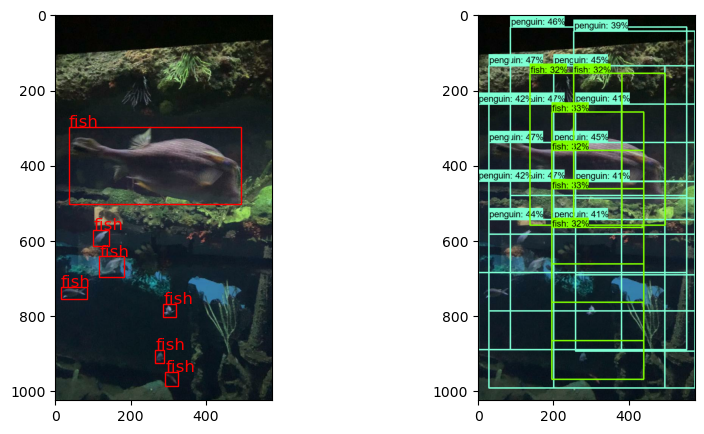

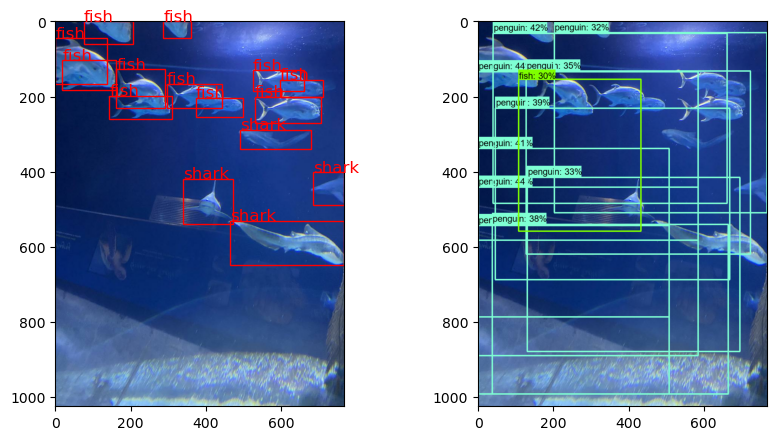

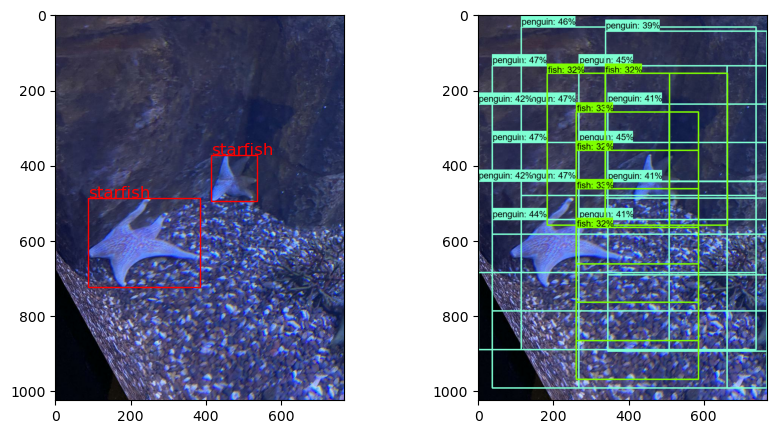

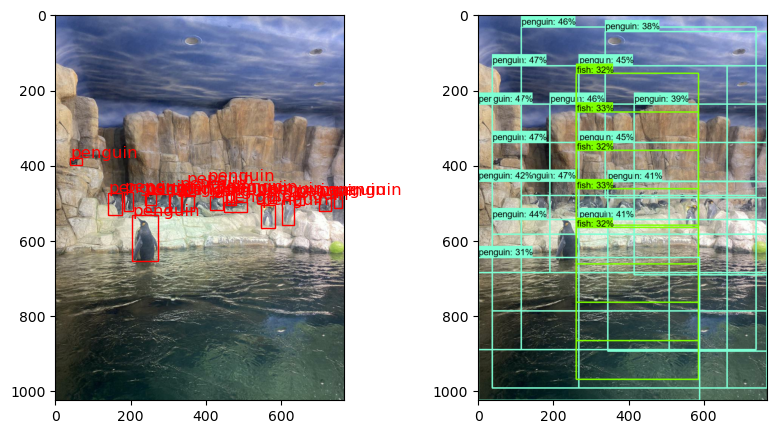

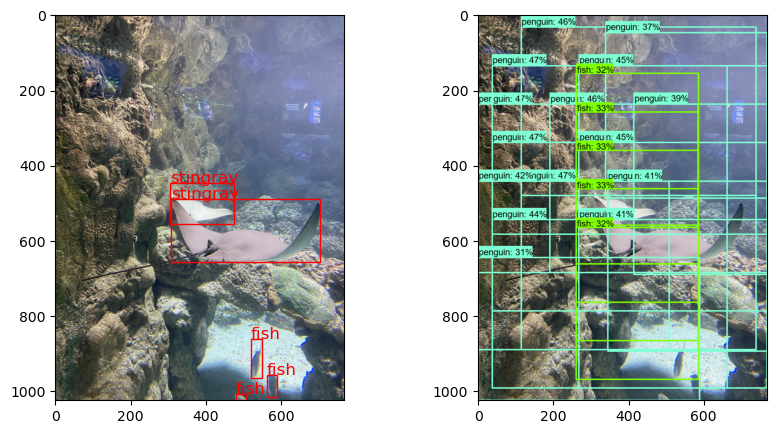

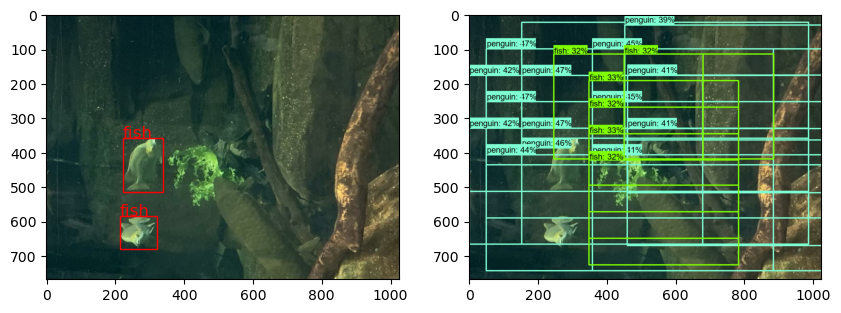

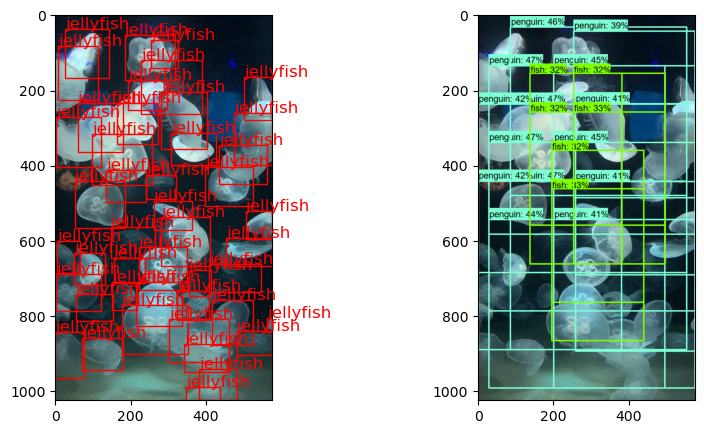

In [27]:
def apply_model_and_visualize_predictions(num_images=5, min_score_thresh=0.1):
    test_dataset = tf.data.TFRecordDataset(test_data_path + 'creatures.tfrecord')

    # Get an iterator over the dataset
    test_iterator = iter(test_dataset)

    for i in range(num_images):
        # Parse the record
        image, bbox, labels = parse_tfrecord(next(test_iterator))
        image_np = np.array(image)

        # Convert tensor bboxes to numpy for plotting
        bbox_np = np.array(bbox)
        labels_np = np.array(labels)
        fig, axs = plt.subplots(1,2,figsize=(10,5))
        draw_bboxes(axs[0], image_np, bbox_np, labels_np)

        image_np = image.numpy()
        input_tensor = tf.convert_to_tensor(image_np)
        input_tensor = input_tensor[tf.newaxis, ...]

        # Apply model to the image
        detections = detector(input_tensor)

        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # Detection classes should be ints
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        image_np_with_detections = image_np.copy()
        image_np_with_detections_uint8 = image_np_with_detections.astype(np.uint8)

        # Visualize the predicted bboxes on the image
        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections_uint8,
                detections['detection_boxes'],
                detections['detection_classes'],
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=20,
                min_score_thresh=min_score_thresh,
                agnostic_mode=False)

        axs[1].imshow(image_np_with_detections_uint8)
        plt.show()

# Now you can call apply_model_and_visualize_predictions with the number of images you want to process.
# For example, to process 5 images, you would do:
apply_model_and_visualize_predictions(num_images=20, min_score_thresh=0.3)


## Compute mAP and recall for the model on the test dataset

In [28]:
from sklearn.metrics import average_precision_score, recall_score
import time


def compute_iou(box1, box2):
    # Convert (xmin, ymin, xmax, ymax) format to (x, y, width, height) format
    box1 = [box1[0], box1[1], box1[2] - box1[0], box1[3] - box1[1]]
    box2 = [box2[0], box2[1], box2[2] - box2[0], box2[3] - box2[1]]
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[0] + box1[2], box2[0] + box2[2])
    yB = min(box1[1] + box1[3], box2[1] + box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = box1[2] * box1[3]
    box2Area = box2[2] * box2[3]
    iou = interArea / float(box1Area + box2Area - interArea)
    return iou

# Define the number of classes
num_classes = 7 # replace this with the number of classes in your dataset

def get_map_recall(ioU_threshold = 0.5):
    test_dataset = tf.data.TFRecordDataset(test_data_path + 'creatures.tfrecord')
    test_iterator = iter(test_dataset)

    ap_values = []
    recall_values = []

    for i in range(9999999):
        start_time = time.time()  # Start recording time
        try:
            image, bbox, labels = parse_tfrecord(next(test_iterator))
        except StopIteration:
            break

        image_np = np.array(image)

        # Convert tensor bboxes to numpy for plotting
        bbox_np = np.array(bbox)
        labels_np = np.array(labels)

        # Apply model to the image
        # detector is the trained object detection model
        input_tensor = tf.convert_to_tensor(image_np)
        input_tensor = input_tensor[tf.newaxis, ...]

        detections = detector(input_tensor)

        # Loop over each unique class in the dataset
        for class_id in range(num_classes):
            # Get ground truth and predicted bounding boxes and scores for the current class
            ground_truth_boxes = bbox_np[labels_np == class_id]
            predicted_boxes = detections['detection_boxes'][detections['detection_classes'] == class_id]
            predicted_scores = detections['detection_scores'][detections['detection_classes'] == class_id]
        
            # Check if there are no predictions or ground truths for this class
            if len(ground_truth_boxes) == 0 or len(predicted_boxes) == 0:
                continue

            # Compute IoU for each predicted bounding box with all ground truth bounding boxes
            ious = np.array([compute_iou(pred_box, gt_box) for pred_box in predicted_boxes for gt_box in ground_truth_boxes])
            ious = ious.reshape((len(predicted_boxes), len(ground_truth_boxes)))

            # Match each prediction to the ground truth box with the highest IoU (if it's above a certain threshold)
            matched_gt_indices = ious.argmax(axis=1)
            ious_max = ious.max(axis=1)
            matches = ious_max > ioU_threshold  # Here 0.5 is the IoU threshold

            # Create binary labels for matched and unmatched predictions
            true_labels = matches.astype(int)
            if true_labels.sum() == 0:
                continue
            # Compute AP for this class
            average_precision = average_precision_score(true_labels, predicted_scores)
            ap_values.append(average_precision) 
            
            # Compute recall for this class
            recall = recall_score(true_labels, predicted_scores > 0.5, zero_division=1)

            recall_values.append(recall)

        
        end_time = time.time()  # End recording time

        print(f'Time taken for image {i}: {end_time - start_time} seconds')

    mAP = np.mean(ap_values)
    mean_recall = np.mean(recall_values)
    print(f'When iou_threshold = {ioU_threshold}, mean_average_precision = {mAP} and mean_recall = {mean_recall}')
    return mAP, mean_recall

mean_average_precision, mean_recall = get_map_recall(ioU_threshold=0.5)

Time taken for image 0: 2.4860215187072754 seconds
Time taken for image 1: 21.852134704589844 seconds
Time taken for image 2: 43.26227331161499 seconds
Time taken for image 3: 2.335026502609253 seconds
Time taken for image 4: 2.267817974090576 seconds
Time taken for image 5: 2.2259974479675293 seconds
Time taken for image 6: 21.318671941757202 seconds
Time taken for image 7: 25.191339254379272 seconds
Time taken for image 8: 2.3259921073913574 seconds
Time taken for image 9: 36.810850620269775 seconds
Time taken for image 10: 1.8899989128112793 seconds
Time taken for image 11: 2.2909984588623047 seconds
Time taken for image 12: 41.49216413497925 seconds
Time taken for image 13: 17.330010652542114 seconds
Time taken for image 14: 38.2740581035614 seconds
Time taken for image 15: 1.7150013446807861 seconds
Time taken for image 16: 50.320762157440186 seconds
Time taken for image 17: 9.069814205169678 seconds
Time taken for image 18: 6.543999910354614 seconds
Time taken for image 19: 1.889

## Plotting the mAP and Recall for different IoU thresholds

Time taken for image 0: 2.2949934005737305 seconds
Time taken for image 1: 20.431042194366455 seconds
Time taken for image 2: 44.12373495101929 seconds
Time taken for image 3: 2.1090004444122314 seconds
Time taken for image 4: 2.0250244140625 seconds
Time taken for image 5: 2.185999631881714 seconds
Time taken for image 6: 21.711012363433838 seconds
Time taken for image 7: 24.30290913581848 seconds
Time taken for image 8: 2.2030019760131836 seconds
Time taken for image 9: 35.072999477386475 seconds
Time taken for image 10: 1.7880244255065918 seconds
Time taken for image 11: 2.493976593017578 seconds
Time taken for image 12: 42.73310613632202 seconds
Time taken for image 13: 17.970675706863403 seconds
Time taken for image 14: 36.47247862815857 seconds
Time taken for image 15: 1.9351301193237305 seconds
Time taken for image 16: 44.68806052207947 seconds
Time taken for image 17: 8.202759265899658 seconds
Time taken for image 18: 6.088334560394287 seconds
Time taken for image 19: 2.2175128

d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Users\User\anaconda3\envs\tf_gpu_2_6_0_env\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Time taken for image 0: 0.22500109672546387 seconds
Time taken for image 1: 0.7359898090362549 seconds
Time taken for image 2: 1.5680041313171387 seconds
Time taken for image 3: 0.12299561500549316 seconds
Time taken for image 4: 0.1120002269744873 seconds
Time taken for image 5: 0.11281347274780273 seconds
Time taken for image 6: 0.8519704341888428 seconds
Time taken for image 7: 1.0200231075286865 seconds
Time taken for image 8: 0.1149752140045166 seconds
Time taken for image 9: 1.4980225563049316 seconds
Time taken for image 10: 0.0751347541809082 seconds
Time taken for image 11: 0.07599759101867676 seconds
Time taken for image 12: 1.5119988918304443 seconds
Time taken for image 13: 0.699385404586792 seconds
Time taken for image 14: 1.6026415824890137 seconds
Time taken for image 15: 0.20997881889343262 seconds
Time taken for image 16: 1.8190181255340576 seconds
Time taken for image 17: 0.3170006275177002 seconds
Time taken for image 18: 0.2729921340942383 seconds
Time taken for ima

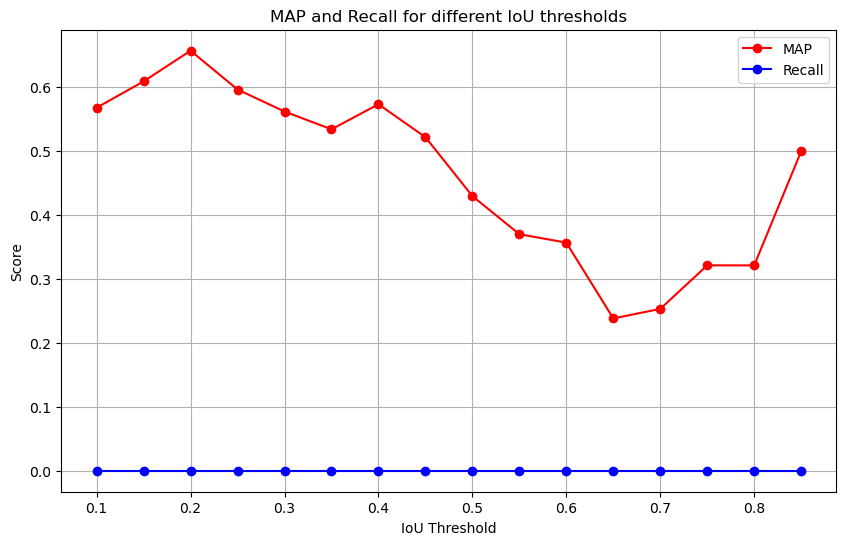

In [29]:

import matplotlib.pyplot as plt
import numpy as np

iou_thresholds = np.arange(0.1, 1.0, 0.05)
map_values = []
recall_values = []

for iou in iou_thresholds:
    map_, recall_ = get_map_recall(iou)
    map_values.append(map_)
    recall_values.append(recall_)

plt.figure(figsize=(10,6))

plt.plot(iou_thresholds, map_values, marker='o', linestyle='-', color='r', label='MAP')
plt.plot(iou_thresholds, recall_values, marker='o', linestyle='-', color='b', label='Recall')

plt.xlabel('IoU Threshold')
plt.ylabel('Score')
plt.title('MAP and Recall for different IoU thresholds')
plt.legend()
plt.grid(True)
plt.show()
